In [25]:
pip install vadersentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display


n_key = 50  # no of words to be considered for BoW (bag of words for each category...if increased then more accurate prediction may be seen)

data = pd.read_csv('/content/shows.csv')

# To drop rows with NaN values for description and category
data.dropna(subset=['description', 'category'], inplace=True)

# Key - category, Value - List of words which map to that category
category_keywords = defaultdict(list)

In [4]:
# Group descriptions by category and extract frequent keywords
for category, group in data.groupby('category'):
    #Extracting all descriptions belonging to a single category group
    all_descriptions = " ".join(group['description'].astype(str).str.lower())
    #To transform list of text data into sparse matrix (Row->Document, Col->Unique word/token, Val->Count of that token in that word)
    vectorizer = CountVectorizer()
    #Converting list of descriptions to document-term matrix
    X = vectorizer.fit_transform([all_descriptions])
    #List of tuples, each tupe -> (<word>, <count>)
    word_counts = list(zip(vectorizer.get_feature_names_out(), X.toarray()[0]))
    #Sorting based on word count to find most frequent word
    word_counts.sort(key=lambda x: x[1], reverse=True)

    # Add top N keywords to the category_keywords dictionary
    if len(word_counts)>=n_key:
      top_n_keywords = [word for word, count in word_counts[:n_key]] #n_key -> hyperparameter given at beginning
    else:
      top_n_keywords = [word for word, count in word_counts[:]] #n_key -> hyperparameter given at beginning

    category_keywords[category] = top_n_keywords

In [5]:
# Create training data with category labels
X = data["description"]
y = data["category"]

# 20% - testing set, 80% - training set, random_state - seed value
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive-Bayes classifier for text classification
# Multinomial - Generalized Binomial (here words follow multinomial distribution)
classifier = MultinomialNB()

model = Pipeline([
    ("vectorizer", CountVectorizer()), # Convert collection of text documents to matrix of word counts
    ("classifier", classifier)
])

model.fit(X_train.astype(str).str.lower(), y_train) # Training the model with splitted data for training

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

Making predictions with test data

In [6]:
predictions = model.predict(X_test.astype(str).str.lower())

result_df = pd.DataFrame({
    'Description': X_test,
    'Actual Category': y_test,
    'Predicted Category': predictions
})

display(result_df)

,Description,Actual Category,Predicted Category
15705,The world's best worst gaming podcast. Coverin...,Games & Hobbies:Other Games,Games & Hobbies
1871,“Come Join Our Circle Jerk Of A Conversation!”...,Comedy,Comedy
7097,The Touch of Gaming podcast is your source for...,Games & Hobbies,Technology
28941,Children's bedtime stories delivered fortnight...,Audiobook,Arts
3226,"Music, Meditations, News and Sahaj Love",Religion & Spirituality,Music
...,...,...,...
6857,More Podcast Less Process features discussions...,Technology,Business
28180,Keeping you up-to-date on the magic ...,Arts,Music
19064,"Made in America is a podcast about spirit, cou...",Comedy,Society & Culture
11680,Making Marriage Cool -- Standing up for Tradit...,Education,Arts


No charts were generated by quickchart


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

Evaluation metrics

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred = model.predict(X_test.astype(str).str.lower())

In [12]:
# Accuracy - High value preferred
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision = Ratio of correctly predicted positives to total predicted positives (High value - Fewer false positives)
precision = precision_score(y_test, y_pred, average='weighted',zero_division=1)
print(f"Precision: {precision:.2f}")

# Recall = Ration of correctly predicted positives to total actual positives (High value - Model do not miss a true positive)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

# F1 Score = Harmonic mean of precision and recall (High value preferred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.42
Precision: 0.61
Recall: 0.42
F1 Score: 0.34


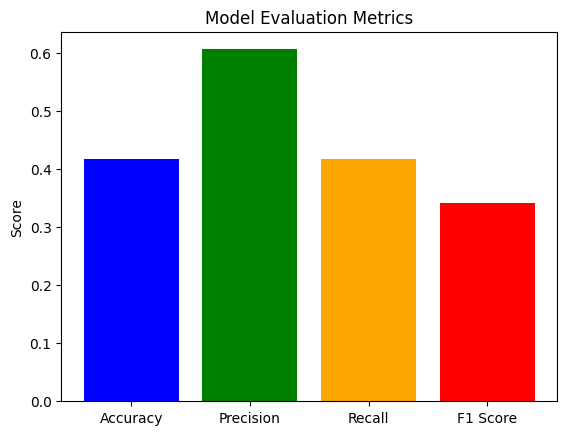

In [13]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.show()

Part 2: Sentiment Analyser using VADER

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Term Frequency-Inverse Document Frequency
'''
Term Frequency - Number of times a term occurs in a document divided by the total number of terms in the document.
Inverse Document Frequency - Logarithm of the total number of documents divided by the number of documents containing the term.
TF-IDF - Product of TF and IDF
'''
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

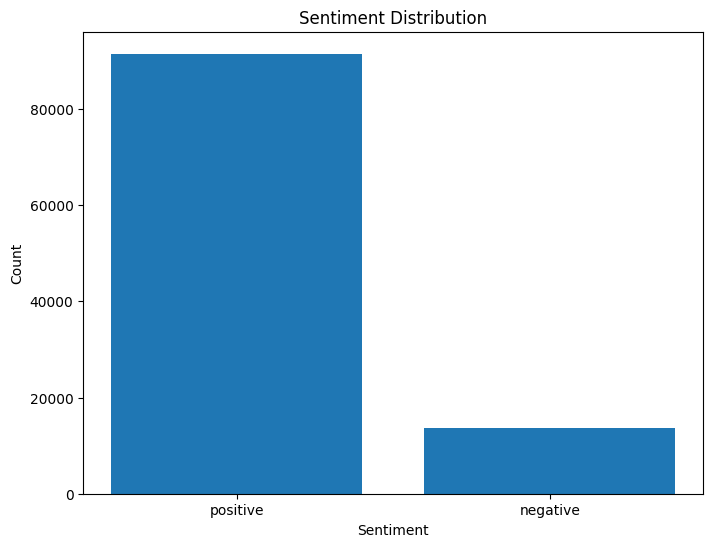

,episode_description,sentiment
0,On the first ever episode of Kream in your Kof...,positive
2,Today’s episode is a sit down Michael and Omar...,positive
3,Join us as we take a look at all current Chief...,positive
4,The modern morality tail of how to stay good f...,positive
5,.,positive
6,Miss Jenn Davis reads the final part of The Si...,positive
7,In today's episode of Chasity and the City we ...,positive
8,Former Boatswain’s Mate Dan Shirey talks pitch...,positive
9,Join us as we learn the tricks and tips of sta...,positive
10,In this episode Dr. Darlene Crone-Todd speaks...,positive


In [30]:
def analyze_sentiment(description): # Given a description text, returns positive or negative
    sentiment_score = analyzer.polarity_scores(description)
    if sentiment_score['compound'] >= 0: # Compound - score calculated from text (Range: -1[negative] to 1[positive])
        return 'positive'
    else:
        return 'negative'

# Loading dataset and excluding unnecessary links
data = pd.read_csv("metadata.tsv", delimiter="\t") # Tab-separated values
columns_to_remove = [
    'show_filename_prefix',
    'episode_filename_prefix',
    'rss_link',
    'episode_uri',
    'publisher',
    'language',
    'show_uri',
    'duration'
]

data = data.drop(columns=columns_to_remove)
data = data.dropna(subset=['episode_description']) # Remove rows without description

analyzer = SentimentIntensityAnalyzer()

data['sentiment'] = data['episode_description'].apply(analyze_sentiment)

# Counting the number of positive and negative sentiments
sentiment_counts = data['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

# Displaying sample positive and negative data instance
positive_records = data[data['sentiment'] == 'positive'].head(15)
negative_records = data[data['sentiment'] == 'negative'].head(15)

balanced_data = pd.concat([positive_records, negative_records])
display(balanced_data[['episode_description', 'sentiment']])